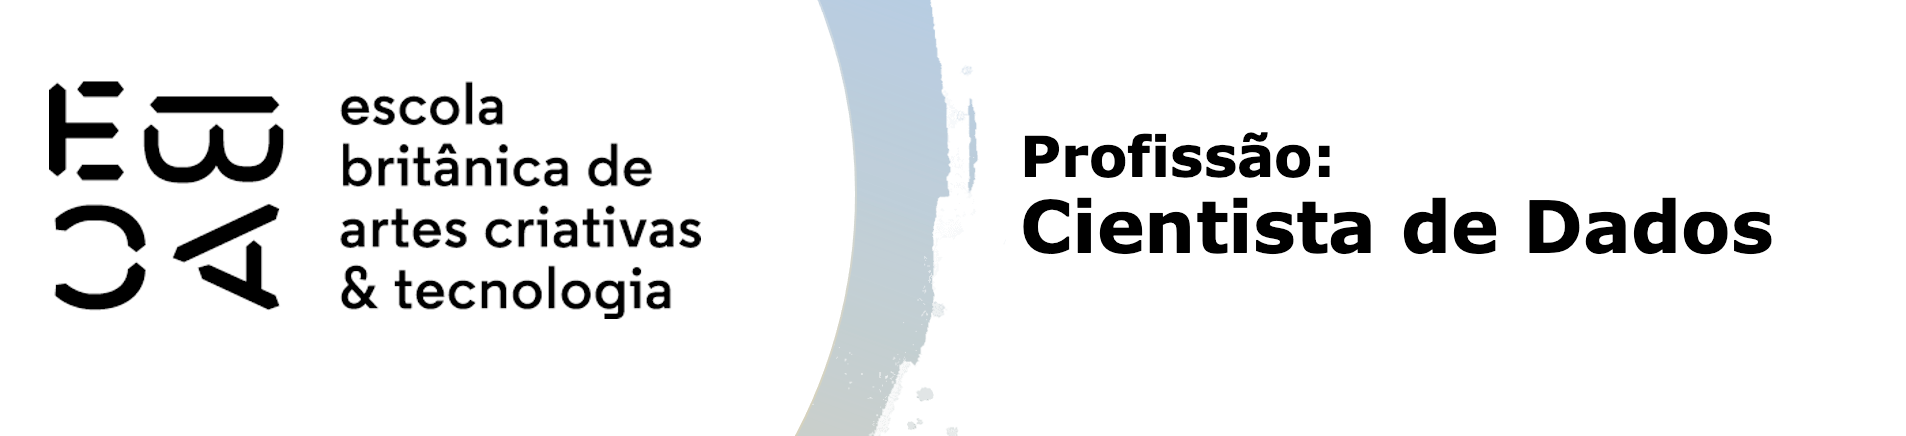

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import t
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

df = pd.read_feather('credit_scoring.ftr')
df['data_ref'] = pd.to_datetime(df['data_ref'])
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [177]:
limite_data = df['data_ref'].max() - pd.DateOffset(months=3)
df_amostra = df[df['data_ref'] < limite_data]
df_amostra

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549995,2015-11-01,2107,F,S,S,0,Empresário,Superior completo,Casado,Casa,27,4.676712,2.0,9766.79,False
549996,2015-11-01,3100,F,S,S,0,Empresário,Superior completo,Casado,Casa,54,15.558904,2.0,55288.72,False
549997,2015-11-01,14692,F,N,N,0,Pensionista,Médio,Solteiro,Casa,63,NaN,1.0,8711.06,False
549998,2015-11-01,2990,M,S,S,0,Assalariado,Superior completo,Casado,Casa,29,1.128767,2.0,51248.02,False


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [180]:
df.groupby(df['data_ref'].dt.to_period('M')).size().reset_index(name='quantidade')


,data_ref,quantidade
0,2015-01,50000
1,2015-02,50000
2,2015-03,50000
3,2015-04,50000
4,2015-05,50000
5,2015-06,50000
6,2015-07,50000
7,2015-08,50000
8,2015-09,50000
9,2015-10,50000


In [182]:
df.select_dtypes(include=['float64', 'int64']).describe()

for col in df.select_dtypes(include=['object', 'category', 'bool']).columns:
    print(f'\n{col}')
    print(df[col].value_counts(normalize=True))
    print(df[col].value_counts())



sexo
sexo
F    0.672773
M    0.327227
Name: proportion, dtype: float64
sexo
F    504580
M    245420
Name: count, dtype: int64

posse_de_veiculo
posse_de_veiculo
N    0.610605
S    0.389395
Name: proportion, dtype: float64
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

posse_de_imovel
posse_de_imovel
S    0.671589
N    0.328411
Name: proportion, dtype: float64
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

tipo_renda
tipo_renda
Assalariado         0.514320
Empresário          0.230283
Pensionista         0.168353
Servidor público    0.086563
Bolsista            0.000481
Name: proportion, dtype: float64
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

educacao
educacao
Médio                  0.675781
Superior completo      0.272408
Superior incompleto    0.039295
Fundamental            0.011433
Pós graduação          0.00108

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


sexo
mau       False     True 
sexo                     
F     91.947759  8.052241
M     92.660337  7.339663

posse_de_veiculo
mau                   False     True 
posse_de_veiculo                     
N                 92.121043  7.878957
S                 92.274847  7.725153

posse_de_imovel
mau                  False     True 
posse_de_imovel                     
N                91.152135  8.847865
S                92.684021  7.315979

tipo_renda
mau                   False     True 
tipo_renda                           
Assalariado       91.908280  8.091720
Bolsista          95.844875  4.155125
Empresário        92.354903  7.645097
Pensionista       91.731675  8.268325
Servidor público  94.191491  5.808509

educacao
mau                      False     True 
educacao                                
Fundamental          90.833819  9.166181
Médio                91.963870  8.036130
Pós graduação        92.733990  7.266010
Superior completo    92.843088  7.156912
Superior incompleto  

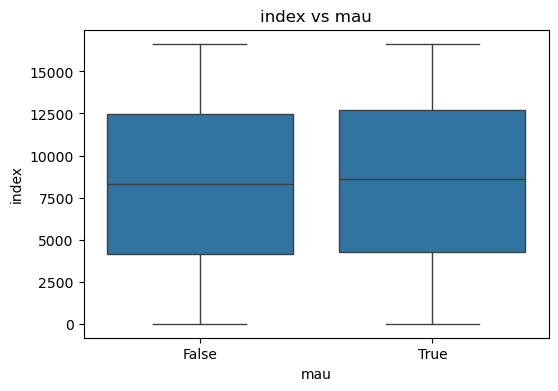

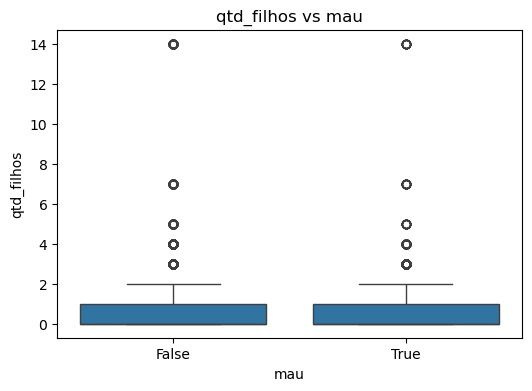

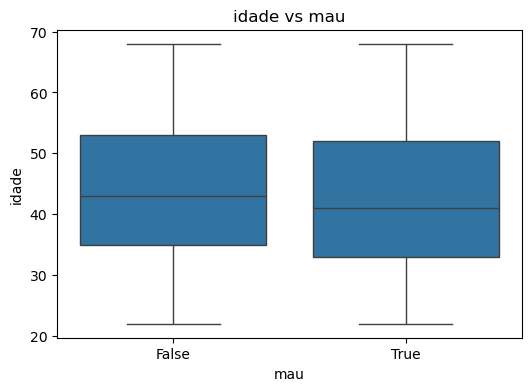

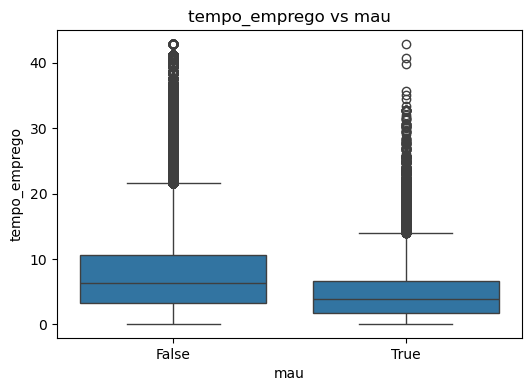

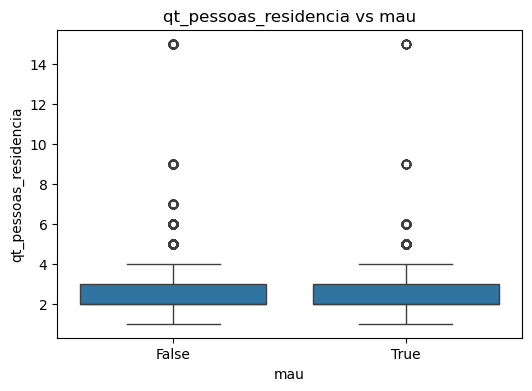

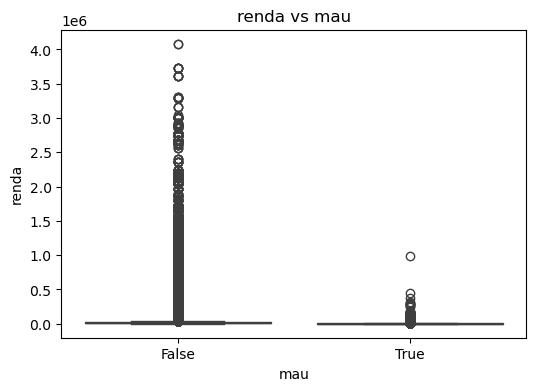

In [185]:
variavel_resposta = 'mau'

for col in df.select_dtypes(include=['object', 'category', 'bool']).columns:
    print(f'\n{col}')
    print(pd.crosstab(df[col], df[variavel_resposta], normalize='index') * 100)

for col in [c for c in df.select_dtypes(include=['float64', 'int64']).columns if c != variavel_resposta]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[variavel_resposta], y=df[col])
    plt.title(f'{col} vs {variavel_resposta}')
    plt.show()


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [190]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
if df['tempo_emprego'].isna().any():
    df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,15
index,int64,0,16650
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


In [192]:
variaveis_numericas = df.select_dtypes(include=['float64', 'int64']).columns
for col in variaveis_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
    print(f'{col}: {len(outliers)} outliers')
for col in variaveis_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], limite_inferior, limite_superior)


index: 0 outliers
qtd_filhos: 10016 outliers
idade: 0 outliers
tempo_emprego: 57123 outliers
qt_pessoas_residencia: 9629 outliers
renda: 79072 outliers


In [194]:
df['renda_log'] = np.log1p(df['renda'])
df['tempo_emprego_log'] = np.log1p(df['tempo_emprego'])
for col in ['qtd_filhos', 'qt_pessoas_residencia']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], limite_inferior, limite_superior)

In [196]:
df['tempo_emprego'] = df['tempo_emprego'].replace(0, np.nan)
df['tempo_emprego_zero'] = (df['tempo_emprego'] == 0).astype(int)
df.replace({'tempo_emprego': {0: np.nan}}, inplace=True)


In [198]:
# Agrupamento de tipo_renda
df['tipo_renda_agrupado'] = df['tipo_renda'].replace({
    'Assalariado': 'Assalariado',
    'Servidor público': 'Estável',
    'Empresário': 'Estável',
    'Bolsista': 'Estável',
    'Pensionista': 'Outros',
    'Autônomo': 'Outros'
})

# Agrupamento de educacao
df['educacao_agrupado'] = df['educacao'].replace({
    'Fundamental': 'Baixa',
    'Médio': 'Baixa',
    'Superior': 'Alta',
    'Pós-graduação': 'Alta'
})

# Agrupamento de estado_civil
df['estado_civil_agrupado'] = df['estado_civil'].replace({
    'Casado': 'Casado',
    'Solteiro': 'Solteiro',
    'Viúvo': 'Não casado',
    'Separado': 'Não casado',
    'Divorciado': 'Não casado'
})

# Agrupamento de tipo_residencia
df['tipo_residencia_agrupado'] = df['tipo_residencia'].replace({
    'Casa': 'Propria',
    'Apartamento': 'Propria',
    'Aluguel': 'Alugada',
    'Com os pais': 'Outros',
    'Outros': 'Outros'
})

def biv_agrupada(var, df):
    df = df.copy()
    df['bom'] = 1 - df['mau']
    
    g = df.groupby(var)

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(),
        var: g['mau'].mean().index,
        'cont': g['mau'].count()
    })

    biv['ep'] = np.sqrt(biv['mau'] * (1 - biv['mau']) / biv['cont'])
    biv['mau_sup'] = biv['mau'] + t.ppf(0.975, biv['cont'] - 1) * biv['ep']
    biv['mau_inf'] = biv['mau'] + t.ppf(0.025, biv['cont'] - 1) * biv['ep']

    biv['logit'] = np.log(biv['mau'] / (1 - biv['mau']))
    biv['logit_sup'] = np.log(biv['mau_sup'] / (1 - biv['mau_sup']))
    biv['logit_inf'] = np.log(biv['mau_inf'] / (1 - biv['mau_inf']))

    woe_base = np.log(df['mau'].mean() / (1 - df['mau'].mean()))
    biv['woe'] = biv['logit'] - woe_base
    biv['woe_sup'] = biv['logit_sup'] - woe_base
    biv['woe_inf'] = biv['logit_inf'] - woe_base

    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    ax[0].plot(biv[var], biv['woe'], ':bo', label='WOE')
    ax[0].plot(biv[var], biv['woe_sup'], 'o:r', label='Limite superior')
    ax[0].plot(biv[var], biv['woe_inf'], 'o:r', label='Limite inferior')
    ax[0].set_xticks(range(len(biv)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(loc='upper right')

    biv['cont'].plot.bar(ax=ax[1])
    ax[1].set_ylabel("Quantidade")
    ax[1].set_title(f"Distribuição por categoria - {var}")

    plt.tight_layout()
    plt.show()
    

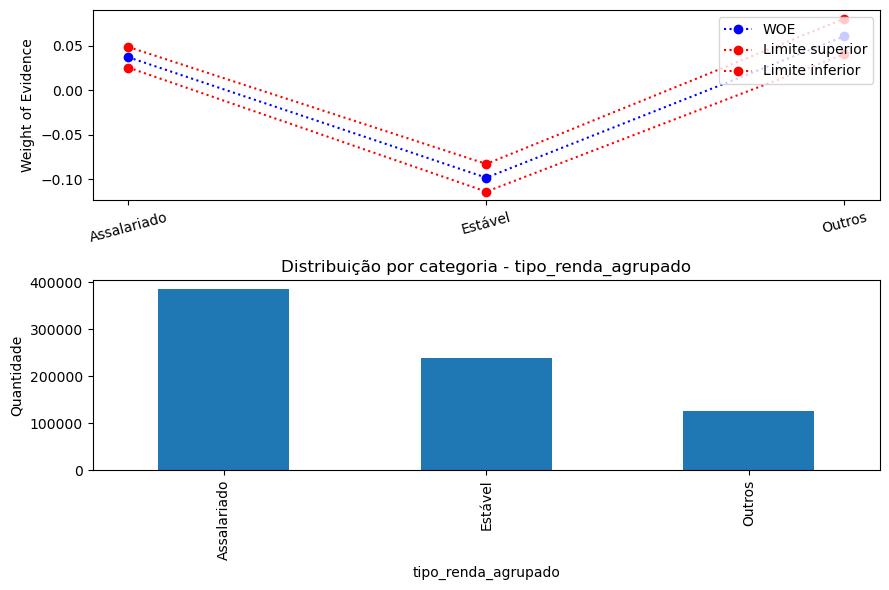

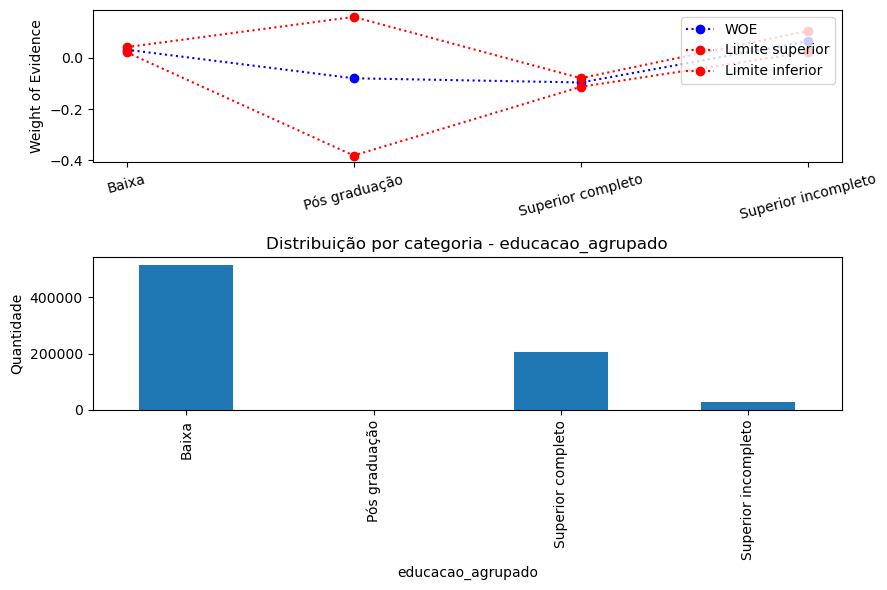

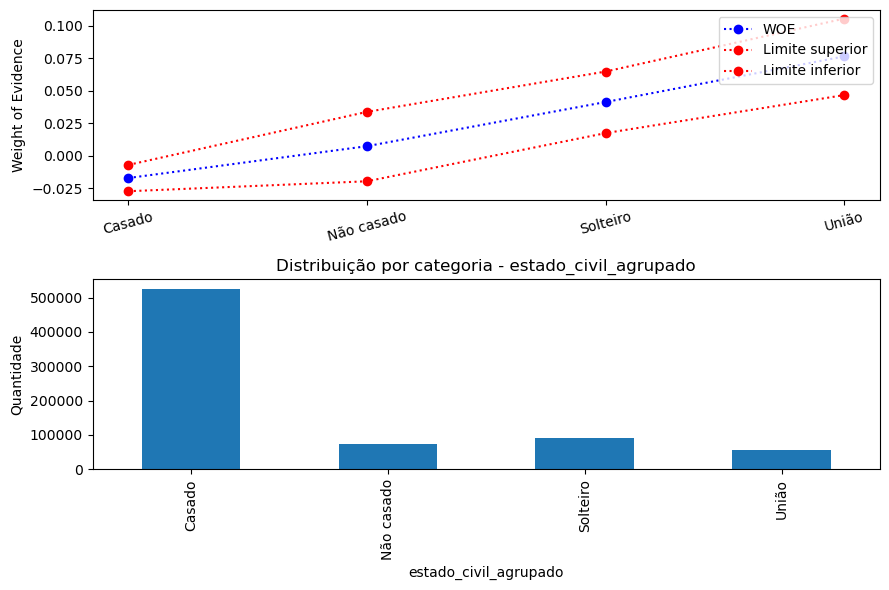

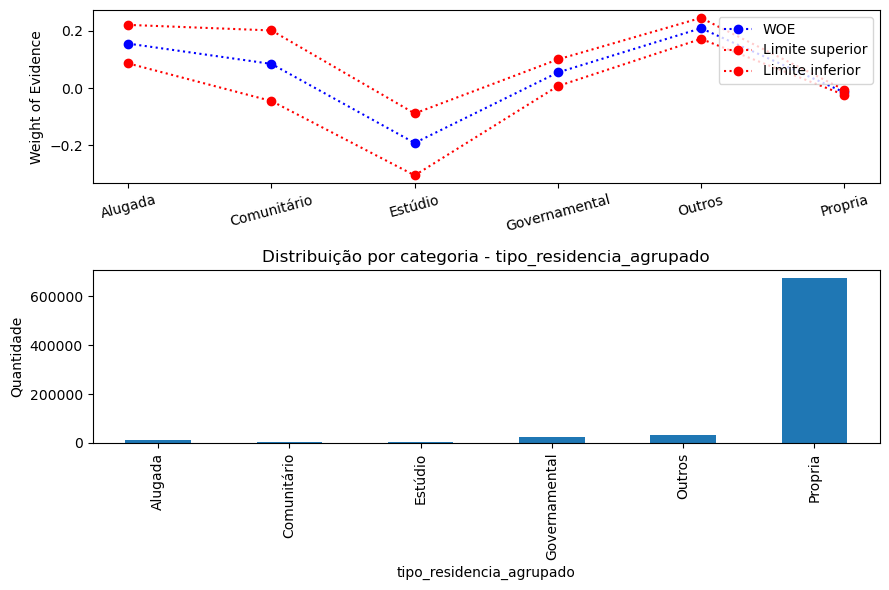

In [200]:
biv_agrupada('tipo_renda_agrupado', df)
biv_agrupada('educacao_agrupado', df)
biv_agrupada('estado_civil_agrupado', df)
biv_agrupada('tipo_residencia_agrupado', df)


In [201]:
df['mau'] = df['mau'].astype(int)
modelo = smf.logit(formula, data=df).fit()

variaveis = ['idade', 'renda_log', 'tempo_emprego_log', 'sexo', 
             'tipo_renda_agrupado', 'educacao_agrupado', 
             'estado_civil_agrupado', 'tipo_residencia_agrupado']

formula = 'mau ~ ' + ' + '.join(variaveis)
modelo = smf.logit(formula, data=df).fit()


Optimization terminated successfully.
         Current function value: 0.234319
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.234319
         Iterations 8


In [202]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               750000
Model:                          Logit   Df Residuals:                   749982
Method:                           MLE   Df Model:                           17
Date:                Fri, 16 May 2025   Pseudo R-squ.:                  0.1458
Time:                        17:19:35   Log-Likelihood:            -1.7574e+05
converged:                       True   LL-Null:                   -2.0575e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     6.0709      0.055    111.346      0.000       5.964       6.178
sexo[T.M]                                     0.0075      0.010      0.734      0.463      -0.013       0.027
tipo_renda_agrupado[T.Estável]                0.0020      0.011      0.185      0.853      -0.019       0.023
tipo_renda_agrupado[T.Outros]                 0.0284      0.017      1.710      0.087      -0.004       0.061
educacao_agrupado[T.Pós graduação]           -0.1024      0.141     -0.725      0.468      -0.379       0.174
educacao_agrupado[T.Superior completo]        0.0012      0.011      0.110      0.913      -0.020       0.022
educacao_agrupado[T.Superior incompleto]      0.0159      0.023      0.680      0.497      -0.030       0.062
estado_civil_agrupado[T.Não casado]          -0.0023      0.016     -0.148      0.883      -0.033       0.029
estado_civil_agrupado[T.Solteiro]             0.0001      0.014      0.009      0.993      -0.027       0.028
estado_civil_agrupado[T.União]                0.0308      0.017      1.824      0.068      -0.002       0.064
tipo_residencia_agrupado[T.Comunitário]      -0.1270      0.076     -1.673      0.094      -0.276       0.022
tipo_residencia_agrupado[T.Estúdio]           0.0421      0.069      0.613      0.540      -0.092       0.177
tipo_residencia_agrupado[T.Governamental]     0.0312      0.045      0.700      0.484      -0.056       0.119
tipo_residencia_agrupado[T.Outros]            0.0251      0.042      0.602      0.547      -0.057       0.107
tipo_residencia_agrupado[T.Propria]          -0.0014      0.037     -0.038      0.970      -0.074       0.071
idade                                         0.0003      0.001      0.510      0.610      -0.001       0.001
renda_log                                    -1.0081      0.005   -201.019      0.000      -1.018      -0.998
tempo_emprego_log                            -0.0231      0.008     -2.830      0.005      -0.039      -0.007
=============================================================================================================
"""

Algumas categorias apresentaram p-valores acima de 0.05, como sexo, tipo_renda_agrupado[T.Estável] e níveis de escolaridade.
Isso indica que elas não são estatisticamente significantes, mas podem ser mantidas por coerência de negócio ou interpretabilidade.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [206]:
df_desenvolvimento = df[df['data_ref'] < limite_data].copy()
df_oot = df[df['data_ref'] >= limite_data].copy()

X_dev = df_desenvolvimento[variaveis]
X_oot = df_oot[variaveis]

y_dev = df_desenvolvimento['mau']
y_oot = df_oot['mau']

y_dev_pred_prob = modelo.predict(df_desenvolvimento)
y_oot_pred_prob = modelo.predict(df_oot)

y_dev_pred_class = (y_dev_pred_prob >= 0.5).astype(int)
y_oot_pred_class = (y_oot_pred_prob >= 0.5).astype(int)

acc_dev = accuracy_score(y_dev, y_dev_pred_class)
acc_oot = accuracy_score(y_oot, y_oot_pred_class)

def ks_score(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return max(tpr - fpr)

ks_dev = ks_score(y_dev, y_dev_pred_prob)
ks_oot = ks_score(y_oot, y_oot_pred_prob)

gini_dev = 2 * roc_auc_score(y_dev, y_dev_pred_prob) - 1
gini_oot = 2 * roc_auc_score(y_oot, y_oot_pred_prob) - 1

print(f"Acurácia: {acc_dev:.4f}")
print(f"KS:       {ks_dev:.4f}")
print(f"Gini:     {gini_dev:.4f}")

print(f"Acurácia: {acc_oot:.4f}")
print(f"KS:       {ks_oot:.4f}")
print(f"Gini:     {gini_oot:.4f}")


Acurácia: 0.9423
KS:       0.3970
Gini:     0.5390
Acurácia: 0.8670
KS:       0.3556
Gini:     0.4893
